# Chapter 9: Random Forest Classifier

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [28]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pylab as plt
from dmba import classificationSummary, gainsChart, liftChart

#### This is the same dataset as used in Homework #3.

In [29]:
hr_df = pd.read_csv('/Users/aminazimi/Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [30]:
hr_df.shape

(1470, 35)

In [31]:
hr_df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [32]:
# Create a y response variable and an X collection of predictors
y = hr_df['Attrition']
X = hr_df.drop(columns=['Attrition'])
print(len(X.columns))

34


In [33]:
# Dummy code in preparation of logistic regression
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)
print(len(X.columns))

47


In [34]:
# Convert the text of Gone to a binary numeric variable (0/1)
y = y.astype('category').cat.codes

# Check for a class imbalance
y.value_counts()

0    1233
1     237
dtype: int64

#### Print out a list of attributes by name and sequence number to prepare for ADASYN

In [35]:
print(pd.DataFrame(X.columns))

                                    0
0                                 Age
1                           DailyRate
2                    DistanceFromHome
3                           Education
4                       EmployeeCount
5                      EmployeeNumber
6             EnvironmentSatisfaction
7                          HourlyRate
8                      JobInvolvement
9                            JobLevel
10                    JobSatisfaction
11                      MonthlyIncome
12                        MonthlyRate
13                 NumCompaniesWorked
14                  PercentSalaryHike
15                  PerformanceRating
16           RelationshipSatisfaction
17                      StandardHours
18                   StockOptionLevel
19                  TotalWorkingYears
20              TrainingTimesLastYear
21                    WorkLifeBalance
22                     YearsAtCompany
23                 YearsInCurrentRole
24            YearsSinceLastPromotion
25          

#### Train/test split with stratification of the response variable

In [36]:
# Split the data into training and test sets (holdout approach)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2019)

#### Fix the class imbalance issue on the training data.

In [37]:
from imblearn.over_sampling import ADASYN

ada = ADASYN()
train_X, train_y = ada.fit_sample(train_X, train_y.ravel())

### Logistic Regression Baseline

In [38]:
# Build a logistic regression model as a baseline
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [39]:
# we are only interested in classification accuracy
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(test_y, logit_reg.predict(test_X))

Confusion Matrix (Accuracy 0.9142)

       Prediction
Actual   0   1
     0 930  56
     1 110 839
Confusion Matrix (Accuracy 0.8367)

       Prediction
Actual   0   1
     0 226  21
     1  27  20


In [40]:
classes = logit_reg.predict(test_X)

print(metrics.classification_report(test_y, classes))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       247
           1       0.49      0.43      0.45        47

    accuracy                           0.84       294
   macro avg       0.69      0.67      0.68       294
weighted avg       0.83      0.84      0.83       294



### Use RandomForest
#### Start by recreating the X and y objects to change one-hot encoding parameter

In [41]:
# Create a y response variable and an X collection of predictors
y = hr_df['Attrition']
X = hr_df.drop(columns=['Attrition'])

In [42]:
# Dummy code in preparation of RandomForest model
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
print(len(X.columns))

55


In [43]:
# Convert the text of Gone to a binary numeric variable (0/1)
y = y.astype('category').cat.codes
y.value_counts()

0    1233
1     237
dtype: int64

In [44]:
# Split the data into training and test sets (holdout approach)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [45]:
from imblearn.over_sampling import ADASYN

ada = ADASYN()
train_X, train_y = ada.fit_sample(train_X, train_y)

In [46]:
# user grid search to find optimized tree
param_grid = {
    'n_estimators': [550, 600, 650], 
    'criterion' : ['entropy', 'gini'],
    'oob_score': ['True'],
    'min_impurity_decrease': [0.0001, .0005, 0.001], 
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14], 
}

In [47]:
gridSearch = GridSearchCV(RandomForestClassifier(), param_grid, cv=2, n_jobs=-1)

gridSearch.fit(train_X, train_y)

print('Initial parameters: ', gridSearch.best_params_)

rfTree = gridSearch.best_estimator_

Initial parameters:  {'criterion': 'entropy', 'min_impurity_decrease': 0.0005, 'min_samples_split': 2, 'n_estimators': 650, 'oob_score': 'True'}


##### Based on these chosen hyperparameters, reprogram the GridSearchCV for a finer search pattern and run again

In [48]:
print(rfTree.oob_score_)

0.9363683393688567


In [49]:
# we are only interested in classification accuracy
classificationSummary(train_y, rfTree.predict(train_X))

classificationSummary(test_y, rfTree.predict(test_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 986   0
     1   0 947
Confusion Matrix (Accuracy 0.8639)

       Prediction
Actual   0   1
     0 236  11
     1  29  18


In [50]:
classes = rfTree.predict(test_X)

print(metrics.classification_report(test_y, classes))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       247
           1       0.62      0.38      0.47        47

    accuracy                           0.86       294
   macro avg       0.76      0.67      0.70       294
weighted avg       0.85      0.86      0.85       294



                              feature  importance       std
52                           Over18_Y    0.000000  0.000000
4                       EmployeeCount    0.000000  0.000000
17                      StandardHours    0.000000  0.000000
32     EducationField_Human Resources    0.001050  0.002481
45          JobRole_Research Director    0.001477  0.003329
48       JobRole_Sales Representative    0.001953  0.003030
41            JobRole_Human Resources    0.002479  0.005130
43                    JobRole_Manager    0.003424  0.006331
37    EducationField_Technical Degree    0.003461  0.004841
29         Department_Human Resources    0.003739  0.007285
42      JobRole_Laboratory Technician    0.003799  0.004254
36               EducationField_Other    0.003828  0.005746
15                  PerformanceRating    0.004056  0.004391
40  JobRole_Healthcare Representative    0.004466  0.006217
34           EducationField_Marketing    0.004548  0.005844
44     JobRole_Manufacturing Director   

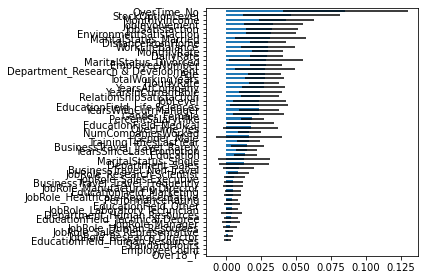

In [51]:
%matplotlib inline
import numpy as np

train_X = pd.DataFrame(train_X)

importances = rfTree.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfTree.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

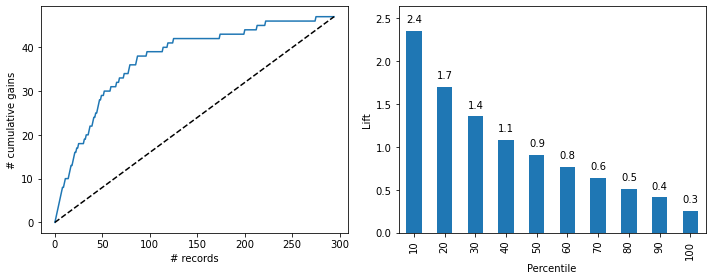

In [52]:
rfTree_pred = rfTree.predict(test_X)
rfTree_proba = rfTree.predict_proba(test_X)
rfTree_result = pd.DataFrame({'actual': test_y, 
                             'p(0)': [p[0] for p in rfTree_proba],
                             'p(1)': [p[1] for p in rfTree_proba],
                             'predicted': rfTree_pred })

df = rfTree_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

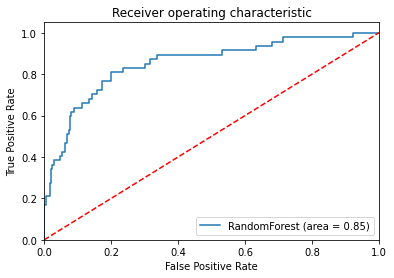

In [53]:
rfTree_pred = rfTree.predict(test_X)
rfTree_proba = rfTree.predict_proba(test_X)

preds = rfTree_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RFTree_ROC')
plt.show()